In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

from neuropacks import ECOG
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.utils import plot_metric_summary

%matplotlib inline

In [2]:
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')

# data_path = '/storage/data/ecog/r32_b7.mat'
# grid_path = '/storage/data/ecog/grdid.mat'

In [3]:
fits_path = os.path.join(os.environ['HOME'],
                         'fits/uoineuro/tuning/ecog/ecog_tuning.h5')

In [4]:
ecog = ECOG(data_path=data_path, grid_path=grid_path)
fits = h5py.File(fits_path, 'r')

In [5]:
dead_electrodes = [0, 19, 21]

# Metric Comparison

In [6]:
baseline = fits['lasso']
algorithms = [fits['uoi_lasso_r2'], fits['uoi_lasso_aic'], fits['uoi_lasso_bic']]

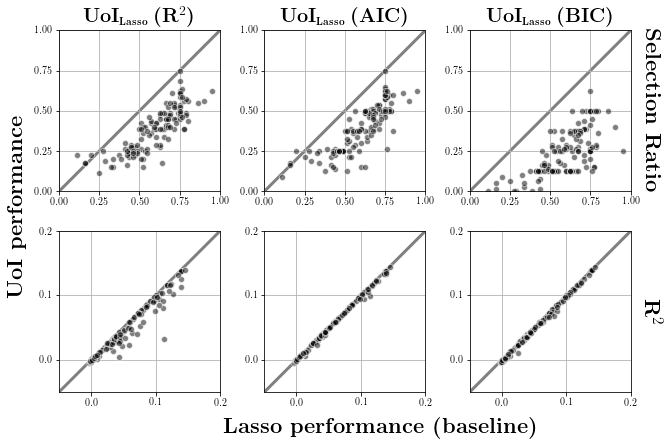

In [7]:
fig, axes = plot_metric_summary(baseline_group=baseline,
                                fits_groups=algorithms,
                                metrics=['selection_ratio', 'r2'],
                                omit_idxs=dead_electrodes)

# additional customizations

# first row: selection ratio
for idx in range(3):
    ax = axes[0, idx]
    ax.set_xlim([0, 1])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.grid('on')

# second row: r2
for idx in range(3):
    ax = axes[1, idx]
    ax.set_xlim([-0.05, 0.2])
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_xlim(),
            color='gray', 
            linewidth=3,
            zorder=-1)
    ax.set_aspect('equal')
    ax.set_xticks([0.0, 0.1, 0.2])
    ax.set_yticks([0.0, 0.1, 0.2])
    ax.grid('on')

for ax in axes.ravel():
    ax.tick_params(labelsize=10)
    ax.set_axisbelow(True)

        
# metric labels
axes[0, -1].set_ylabel(
    r'\textbf{Selection Ratio}',
    fontsize=22,
    labelpad=30,
    rotation=270)
axes[1, -1].set_ylabel(
    r'$\mathbf{R}^2$',
    fontsize=22,
    labelpad=30,
    rotation=270)
axes[0, -1].yaxis.set_label_position('right')
axes[1, -1].yaxis.set_label_position('right')

# uoi approach labels
axes[0, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[0, 2].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}',
                     fontsize=20)

# algorithm labels
fig.text(
    x=0.55, y=-0.01,
    s=r'\textbf{Lasso performance (baseline)}',
    fontsize=22,
    horizontalalignment='center',
    verticalalignment='center')

fig.text(
    x=-0.01, y=0.5,
    s=r'\textbf{UoI performance}',
    fontsize=22,
    rotation=90,
    horizontalalignment='center',
    verticalalignment='center')
    
plt.tight_layout()
plt.savefig('ecog_tuning_metric_summary.pdf', bbox_inches='tight')

# Grid of Tuning Curves

In [8]:
lasso_coefs = np.mean(fits['lasso/tuning_coefs'], axis=0)
lasso_intercepts = np.mean(fits['lasso/intercepts'], axis=0)

uoi_r2_coefs = np.mean(fits['uoi_lasso_r2/tuning_coefs'], axis=0)
uoi_r2_intercepts = np.mean(fits['uoi_lasso_r2/intercepts'], axis=0)

uoi_aic_coefs = np.mean(fits['uoi_lasso_aic/tuning_coefs'], axis=0)
uoi_aic_intercepts = np.mean(fits['uoi_lasso_aic/intercepts'], axis=0)

uoi_bic_coefs = np.mean(fits['uoi_lasso_bic/tuning_coefs'], axis=0)
uoi_bic_intercepts = np.mean(fits['uoi_lasso_bic/intercepts'], axis=0)

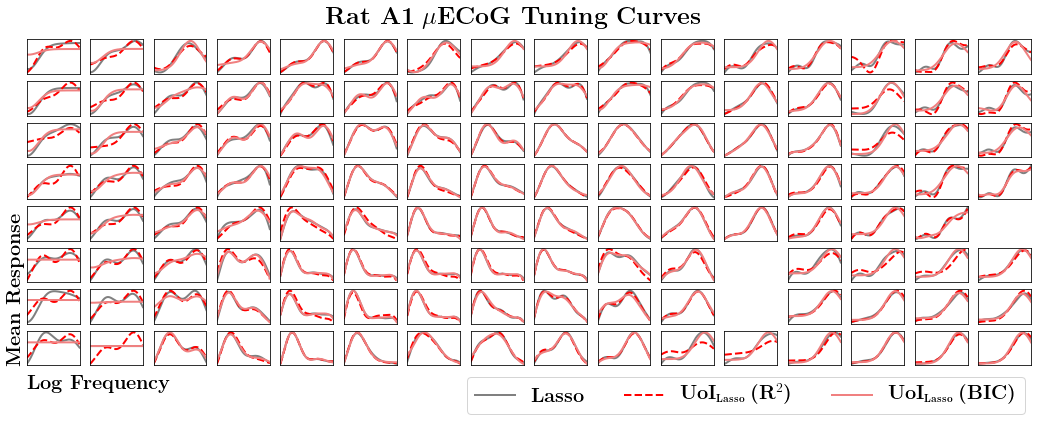

In [9]:
fig, axes = plt.subplots(8, 16, figsize=(18, 6))

for electrode in range(ecog.n_electrodes):
    x, y = ecog.get_xy_for_electrode(electrode)
    ax = axes[x, y]
    
    if electrode in dead_electrodes:
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    frequencies = np.linspace(ecog.freq_set[0], ecog.freq_set[-1], 100000)
    _, lasso_tc = ecog.get_tuning_curve(tuning_coefs=lasso_coefs[electrode],
                                        frequencies=frequencies)
    _, uoi_r2_tc = ecog.get_tuning_curve(tuning_coefs=uoi_r2_coefs[electrode],
                                         frequencies=frequencies)
    _, uoi_aic_tc = ecog.get_tuning_curve(tuning_coefs=uoi_aic_coefs[electrode],
                                          frequencies=frequencies)
    _, uoi_bic_tc = ecog.get_tuning_curve(tuning_coefs=uoi_bic_coefs[electrode],
                                          frequencies=frequencies)
    
    ax.plot(
        frequencies, lasso_intercepts[electrode] + lasso_tc,
        color='gray',
        linewidth=2,
        alpha=1,
        zorder=-1,
        label=r'\textbf{Lasso}')

    ax.plot(
        frequencies, uoi_r2_intercepts[electrode] + uoi_r2_tc,
        color='red',
        linewidth=2,
        linestyle='--',
        alpha=1,
        label=r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}')

    axes[x, y].plot(
         frequencies, uoi_bic_intercepts[electrode] + uoi_bic_tc,
         color='lightcoral',
         linewidth=2,
         alpha=1,
         label=r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}')

    ax.set_xscale('log')
    ax.set_xlim([frequencies[0], frequencies[-1]])
    ax.set_xticks([])
    ax.set_yticks([])

fig.text(
    x=0.125, y=0.08,
    s=r'\textbf{Log Frequency}',
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=20)

fig.text(
    x=0.11, y=0.3,
    s=r'\textbf{Mean Response}',
    horizontalalignment='left',
    verticalalignment='center',
    fontsize=20,
    rotation=90)

fig.text(
    x=0.50, y=0.93,
    s=r'\textbf{Rat A1} $\mu$\textbf{ECoG Tuning Curves}',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=25)

axes[0, 0].legend(
    loc='lower center',
    bbox_transform=fig.transFigure,
    bbox_to_anchor=(0.68, -0.01),
    ncol=3,
    fancybox=True,
    prop={'size': 20})

plt.tight_layout()
plt.savefig('ecog_tuning_curve_grid.pdf', bbox_inches='tight')

# Tonotopy Maps

In [10]:
lasso_coefs = np.mean(fits['lasso/tuning_coefs'], axis=0)
uoi_r2_coefs = np.mean(fits['uoi_lasso_r2/tuning_coefs'], axis=0)
uoi_aic_coefs = np.mean(fits['uoi_lasso_aic/tuning_coefs'], axis=0)
uoi_bic_coefs = np.mean(fits['uoi_lasso_bic/tuning_coefs'], axis=0)
coefs = [lasso_coefs, uoi_r2_coefs, uoi_aic_coefs, uoi_bic_coefs]

In [11]:
pref_frequencies = []
for coef in coefs:
    pref_freq = calculate_best_frequencies_ecog(coef,
                                                ecog,
                                                return_grid=True,
                                                omit_idxs=dead_electrodes)
    pref_frequencies.append(pref_freq)

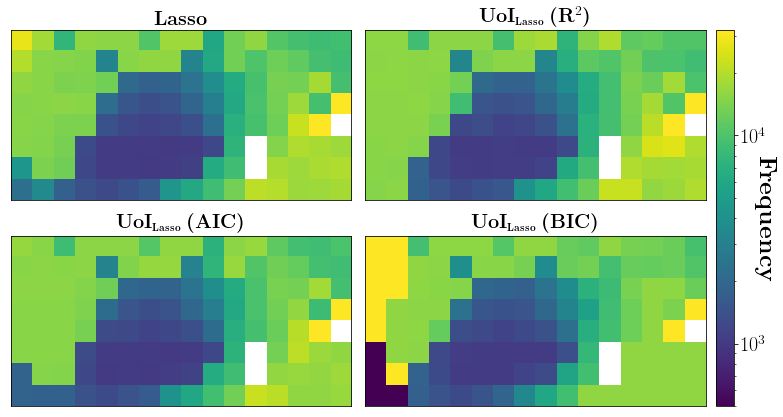

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for idx, ax in enumerate(axes.ravel()):
    img = ax.imshow(pref_frequencies[idx],
                    cmap='viridis',
                    vmin=ecog.freq_set[0],
                    vmax=ecog.freq_set[-1],
                    norm=matplotlib.colors.LogNorm(),
                    origin='upper')
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[0, 0].set_title(r'\textbf{Lasso}', fontsize=20)
axes[0, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(}$\mathbf{R}^2$\textbf{)}',
                     fontsize=20)
axes[1, 0].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(AIC)}',
                     fontsize=20)
axes[1, 1].set_title(r'\textbf{UoI}$_{\normalsize\textbf{Lasso}}$ \textbf{(BIC)}',
                     fontsize=20)

cax = fig.add_axes([1, 0.05, 0.025, 0.87])
cb = fig.colorbar(img, cax=cax, orientation='vertical')
cb.set_ticks([1000, 10000])
cb.set_label(r'\textbf{Frequency}',
             rotation=270,
             labelpad=10)
plt.tight_layout()
plt.savefig('ecog_tonotopy_maps.pdf', bbox_inches='tight')

# Comparison to SNR

In [13]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG',
    electrodes=None,
    transform=None)

In [14]:
coef_of_var = np.mean(Y, axis=0) / np.std(Y, axis=0)
uoi_bic_sr = np.count_nonzero(np.median(fits['uoi_lasso_bic/tuning_coefs'], axis=0), axis=-1) / 8
uoi_bic_r2 = np.mean(fits['uoi_lasso_bic/r2'], axis=0)

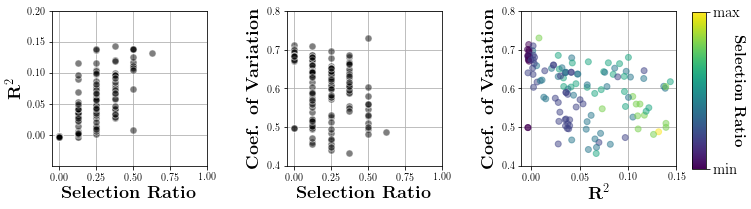

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))


axes[0].scatter(
    uoi_bic_sr,
    uoi_bic_r2,
    alpha=0.50,
    s=50,
    color='k',
    edgecolor='white')

axes[1].scatter(
    uoi_bic_sr,
    coef_of_var,
    alpha=0.50,
    s=50,
    color='k',
    edgecolor='white')

axes[2].scatter(
    uoi_bic_r2,
    coef_of_var,
    c=plt.get_cmap('viridis')((255 * uoi_bic_sr / np.max(uoi_bic_sr)).astype('int')),
    alpha=0.50)

cax = fig.add_axes([0.98, 0.2, 0.02, 0.73])
cb = fig.colorbar(
    matplotlib.cm.ScalarMappable(cmap='viridis'),
    ticks=[0, 1],
    cax=cax,
    orientation='vertical')
cb.set_label(r'\textbf{Selection Ratio}',
             fontsize=15,
             rotation=270)
cb.ax.tick_params(labelsize=15)
cb.ax.set_yticklabels(['min', 'max'])

axes[0].set_xlim([-0.05, 1])
axes[0].set_xticks([0., 0.25, 0.5, 0.75, 1.0])
axes[0].set_ylim([-0.05, 0.2])
axes[0].set_yticks([0, 0.05, 0.1, 0.15, 0.2])

axes[1].set_xlim([-0.05, 1])
axes[1].set_xticks([0., 0.25, 0.5, 0.75, 1.0])
axes[1].set_ylim([0.4, 0.8])
axes[1].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])

axes[2].set_xlim([-0.01, 0.15])
axes[2].set_yticks([0, 0.05, 0.1, 0.15])
axes[2].set_ylim([0.4, 0.8])
axes[2].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])

# axes labels
axes[0].set_xlabel(r'\textbf{Selection Ratio}',
                   fontsize=18)
axes[0].set_ylabel(r'$\mathbf{R}^2$',
                   fontsize=18)

axes[1].set_xlabel(r'\textbf{Selection Ratio}',
                   fontsize=18)
axes[1].set_ylabel(r'\textbf{Coef. of Variation}',
                   fontsize=18)

axes[2].set_xlabel(r'$\mathbf{R}^2$',
                   fontsize=18)
axes[2].set_ylabel(r'\textbf{Coef. of Variation}',
                   fontsize=18)
for ax in axes:
    ax.grid('on')
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=10)
    ax.set_aspect((ax.get_xlim()[1] - ax.get_xlim()[0]) /
                  (ax.get_ylim()[1] - ax.get_ylim()[0]))

plt.tight_layout()
plt.savefig('ecog_tuning_snr_comparison.pdf', bbox_inches='tight')